<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesor: Tomás Fontecilla </em><br>

</div>

### **TAREA: CNN (Red Neuronal Convolucional)**

*29 de Noviembre de 2024*

**Nombre Estudiante(s)**: Juan Ugalde - Victor Saldivia - Joaquin Leiva

### **INTRODUCCIÓN**

En esta tarea, el objetivo es comparar el rendimiento de dos arquitecturas de redes neuronales 
en un problema de clasificación binaria: Muffins vs Chihuahuas. 

El próposito de la tarea es:
1. Aplicar un Perceptrón Multicapa (MLP) para clasificar imágenes.
2. Implementar una Red Neuronal Convolucional (CNN) para resolver el mismo problema.
3. Comparar el rendimiento de ambas arquitecturas en términos de precisión y pérdida.

### **OBJETIVOS**

**Objetivo General**  
Evaluar el desempeño de dos enfoques distintos de redes neuronales aplicados a un problema 
de clasificación de imágenes.

**Objetivos Específicos**
- Diseñar y entrenar un modelo MLP y otro CNN utilizando técnicas de aumento de datos.
- Analizar la evolución de las métricas de precisión y pérdida durante el entrenamiento.
- Evaluar ambos modelos en un conjunto de prueba para determinar cuál ofrece mejor rendimiento.
- Obtener conclusiones con base en la comparación de resultados.

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import zipfile
from sklearn.metrics import classification_report, confusion_matrix
import random

import warnings
warnings.filterwarnings('ignore')

# Fijar un random seed para reproducibilidad
np.random.seed(123)
tf.random.set_seed(123)
random.seed(123)

### **PREPROCESAMIENTO DE DATOS**

En esta sección, preparamos el conjunto de datos para su uso en el modelo. 
Esto incluye:
- La normalización de los valores de píxeles al rango [0, 1].
- La división del conjunto de datos en entrenamiento, validación y prueba.
- La aplicación de técnicas de aumento de datos, como rotaciones, desplazamientos y zoom.
Estas acciones aseguran que el modelo reciba datos consistentes y variados para mejorar su capacidad de generalización.


#### **Descomprimir Archivo**

In [2]:
dataset_path = './data/archive.zip'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

In [3]:
# Definición de rutas de los datos
base_dir = './data/train'
test_dir = './data/test'

# Generador de datos con normalización y aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,  # Escala los valores de píxeles a [0, 1]
    validation_split=0.2,  # Divide los datos en entrenamiento y validación
    rotation_range=20,  # Rotación aleatoria de hasta 20 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    horizontal_flip=True,  # Volteo horizontal
    zoom_range=0.2  # Zoom aleatorio
)

# Generador de datos para el conjunto de entrenamiento
train_data = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),  # Redimensiona las imágenes a 128 x 128 píxeles
    batch_size=64,
    class_mode='binary',  # Clasificación binaria: muffin (0) o chihuahua (1)
    subset='training'
)

# Generador de datos para el conjunto de validación
val_data = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

# Generador de datos para el conjunto de prueba (sin aumento de datos)
test_datagen = ImageDataGenerator(rescale=1./255)  # Solo normalización
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='binary'
)

Found 3788 images belonging to 2 classes.
Found 945 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


### **VISUALIZACIÓN DE IMÁGENES AUMENTADAS**

En esta parte se muestran ejemplos de imágenes generadas mediante el aumento de datos. 
Esto se hace para verificar si las técnicas de preprocesamiento, como rotaciones y desplazamientos, se aplicaron correctamente.

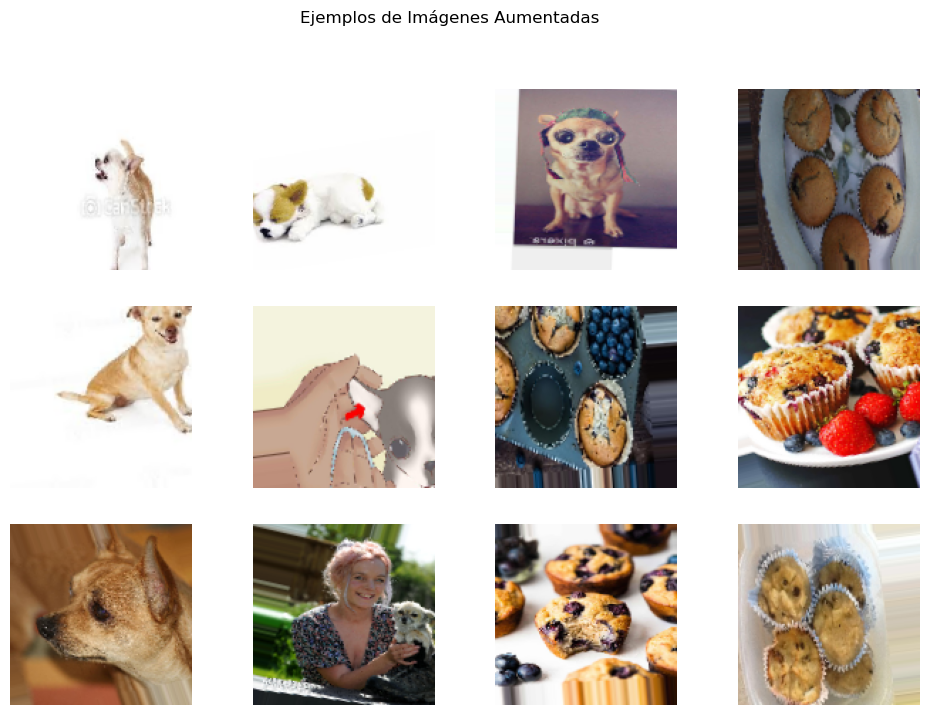

In [14]:
sample_images, _ = next(train_data)
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.suptitle('Ejemplos de Imágenes Aumentadas')
plt.show()

### **MODELO PERCEPTRÓN MULTICAPA (MLP)**

Diseñamos un modelo de Perceptrón Multicapa (MLP)
- La capa de entrada aplana las imágenes para convertirlas en un vector unidimensional.
- Se añaden capas densas con funciones de activación ReLU para capturar relaciones complejas.
- Se utilizan capas de Dropout para reducir el sobreajuste.
- La capa de salida utiliza una función de activación sigmoide para clasificar imágenes en dos categorías: muffin o chihuahua.

In [15]:
mlp_model = Sequential([
    Flatten(input_shape=(128, 128, 3)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo MLP
mlp_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/Users/jugalde/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-12-01 19:11:32.441389: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-01 19:11:32.441437: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-01 19:11:32.441452: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-01 19:11:32.441669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-01 19:11:32.441689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow devi

#### **Entrenamiento del Modelo Perceptrón Multicapa**

Se entrena el modelo MLP utilizando el conjunto de entrenamiento y validación.
Durante el entrenamiento:
- Se monitoriza la precisión y la pérdida en ambos conjuntos.
- Permitiendo evaluar cómo se está comportando el modelo a lo largo de los ciclos de entrenamiento.

In [16]:
mlp_history = mlp_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    batch_size=64
)

/Users/jugalde/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2024-12-01 19:11:40.368064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - accuracy: 0.5039 - loss: 8.1896 - val_accuracy: 0.5534 - val_loss: 0.6843
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 314ms/step - accuracy: 0.5278 - loss: 0.6945 - val_accuracy: 0.5407 - val_loss: 0.6922
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 307ms/step - accuracy: 0.5467 - loss: 0.6919 - val_accuracy: 0.5407 - val_loss: 0.6913
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 301ms/step - accuracy: 0.5379 - loss: 0.6911 - val_accuracy: 0.5407 - val_loss: 0.6907
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 311ms/step - accuracy: 0.5434 - loss: 0.6907 - val_accuracy: 0.5407 - val_loss: 0.6903
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 310ms/step - accuracy: 0.5401 - loss: 0.6906 - val_accuracy: 0.5407 - val_loss: 0.6901
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 325ms/step - accuracy: 0.5324 - loss: 0.6909 - val_accuracy: 0.5397 - val_loss: 0.6900
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - accuracy: 0.5459 - loss: 0.6895 - val_accuracy: 0.538

#### **Visualización del Rendimiento del Modelo**

A continuación, se visualizan las métricas de rendimiento del modelo (precisión y pérdida) durante el entrenamiento.
Esto ayuda a identificar si el modelo está mejorando con el tiempo o si está ocurriendo un sobreajuste.

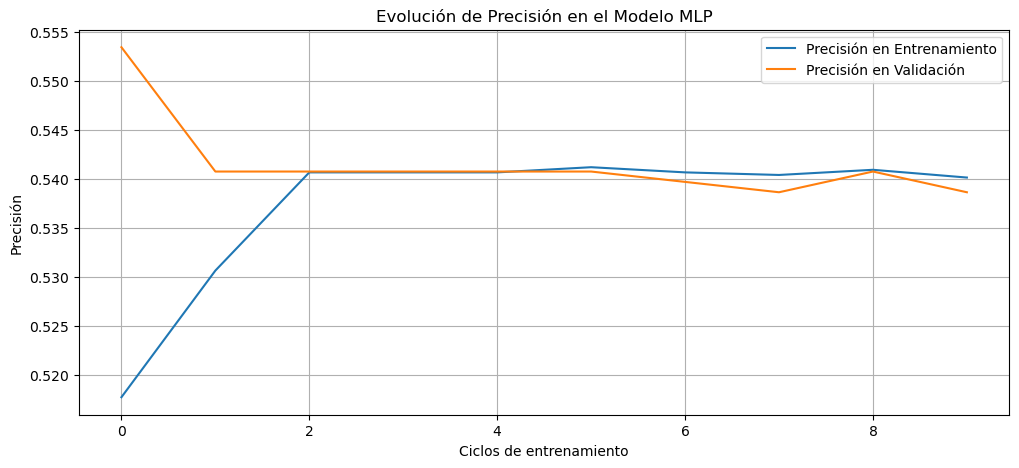

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(mlp_history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(mlp_history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Ciclos de entrenamiento')
plt.ylabel('Precisión')
plt.title('Evolución de Precisión en el Modelo MLP')
plt.legend()
plt.grid(True)
plt.show()

#### **Evaluación del Modelo MLP**


In [33]:
# Evaluar el modelo MPL
loss, accuracy = mlp_model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.5404 - loss: 0.6899
Test Loss: 0.6899
Test Accuracy: 0.5405


In [65]:
# Obtener predicciones en base al modelo
test_data.reset()  
predictions = mlp_model.predict(test_data) 
predicted_classes = (predictions > 0.5).astype(int)  # Convertir probabilidades a clases

# Obtener las clases reales
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys()) 

# Resultado de la clasficación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Matriz de confusión
mpl_conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Matriz de confusión, modelo MLP:")
print(mpl_conf_matrix)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step
              precision    recall  f1-score   support

   chihuahua       0.54      1.00      0.70       640
      muffin       0.00      0.00      0.00       544

    accuracy                           0.54      1184
   macro avg       0.27      0.50      0.35      1184
weighted avg       0.29      0.54      0.38      1184

Matriz de confusión, modelo MLP:
[[640   0]
 [544   0]]


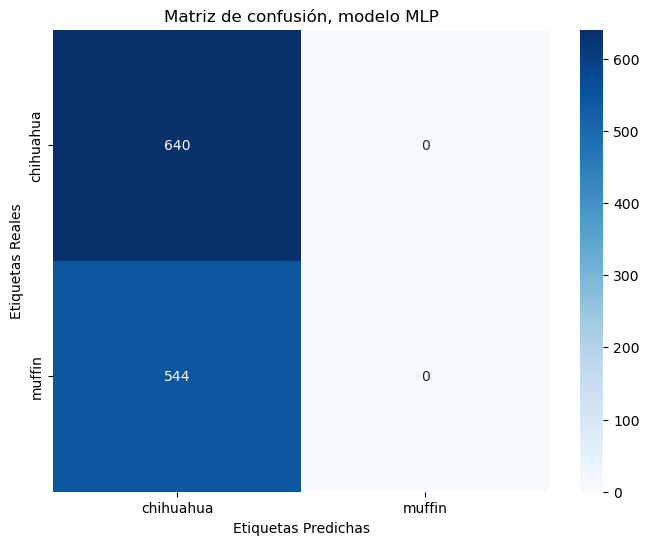

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(mpl_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de confusión, modelo MLP")
plt.ylabel("Etiquetas Reales")
plt.xlabel("Etiquetas Predichas")
plt.show()

### **MODELO CONVOLUCIONAL**

Diseñamos un modelo utilizan una red neuronal convolucional (CNN) con los siguientes pasos:

- Capas de convolución para obtener caracteristicas espaciales de las imagenes
- Se incluyeron capas de normalización por batch y pooling, para disminuir el tiempo de computo y retener las caracteristicas mas importantes.




In [52]:

# Define the enhanced model
cnn_model = Sequential([
    # Capa 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Capa 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Capa 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Capa 4
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Flattening
    Flatten(),
    
    # Fully Connected Dense Layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Regularization to prevent overfitting
    
    Dense(256, activation='relu'),
    Dropout(0.5),  # Another layer of regularization
    
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
cnn_model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [55]:
cnn_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    batch_size=64
)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.9067 - loss: 0.2569 - val_accuracy: 0.5873 - val_loss: 0.9507
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 0.9134 - loss: 0.2365 - val_accuracy: 0.8889 - val_loss: 0.2904
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.9091 - loss: 0.2269 - val_accuracy: 0.9164 - val_loss: 0.2319
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 312ms/step - accuracy: 0.9100 - loss: 0.2345 - val_accuracy: 0.8815 - val_loss: 0.2728
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.9202 - loss: 0.1976 - val_accuracy: 0.8603 - val_loss: 0.3604
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step - accuracy: 0.9227 - loss: 0.1950 - val_accuracy: 0.9185 - val_loss: 0.1870
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 0.9330 - loss: 0.1798 - val_accuracy: 0.6360 - val_loss: 1.3286
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 315ms/step - accuracy: 0.9175 - loss: 0.2025 - val_accu

#### **Visualización del Rendimiento del Modelo**

A continuación, se visualizan las métricas de rendimiento del modelo (precisión y pérdida) durante el entrenamiento.
Esto ayuda a identificar si el modelo está mejorando con el tiempo o si está ocurriendo un sobreajuste.

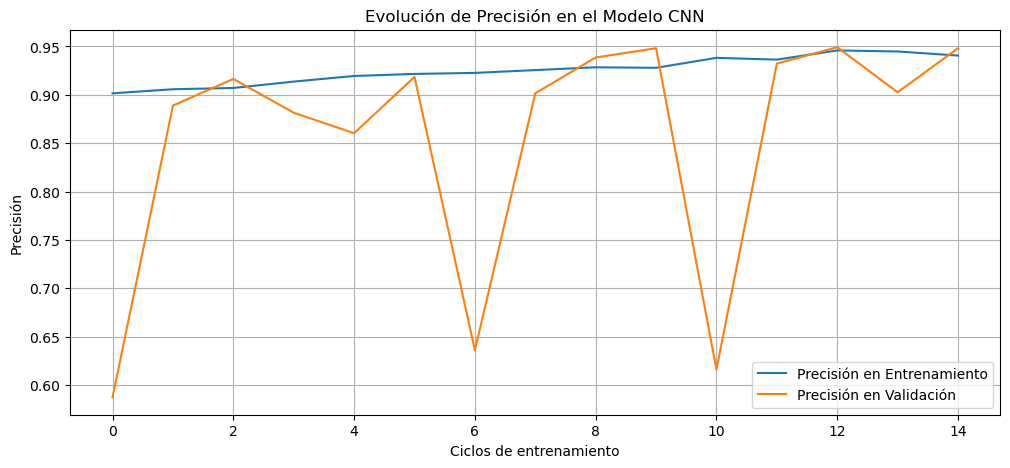

In [56]:
plt.figure(figsize=(12, 5))
plt.plot(cnn_history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(cnn_history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Ciclos de entrenamiento')
plt.ylabel('Precisión')
plt.title('Evolución de Precisión en el Modelo CNN')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# Guardamos el modelo para reducir el tiempo de calculo en futuros analisis
cnn_model.save('cnn_model.keras')

In [57]:
# Evaluar el modelo CBB
loss, accuracy = cnn_model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.9249 - loss: 0.2331
Test Loss: 0.2544
Test Accuracy: 0.9105


In [63]:
# Obtener predicciones en base al modelo
test_data.reset()  
predictions = cnn_model.predict(test_data) 
predicted_classes = (predictions > 0.5).astype(int)  # Convertir probabilidades a clases

# Obtener las clases reales
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys()) 

# Resultado de la clasficación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Matriz de confusión
cnn_conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Matriz de confusión, modelo MLP:")
print(cnn_conf_matrix)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step
              precision    recall  f1-score   support

   chihuahua       0.54      0.61      0.58       640
      muffin       0.46      0.39      0.42       544

    accuracy                           0.51      1184
   macro avg       0.50      0.50      0.50      1184
weighted avg       0.51      0.51      0.51      1184

Matriz de confusión, modelo MLP:
[[393 247]
 [331 213]]


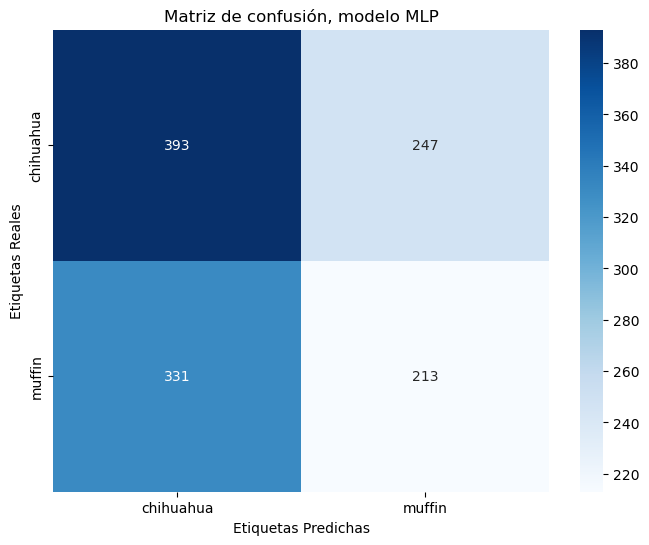

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de confusión, modelo MLP")
plt.ylabel("Etiquetas Reales")
plt.xlabel("Etiquetas Predichas")
plt.show()